# Deep Learning

In [11]:
# ---------------------------------------------
# Library
# ---------------------------------------------
import pandas, datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tqdm.keras import TqdmCallback

In [2]:
# ---------------------------------------------
# Applied functions
# ---------------------------------------------
# To manipulate the dataframe more efficient, 
# using dataframe.apply instead of iterrows

def timestamp_to_class(x):
    in30min = 30*60
    in60min = 2*in30min
    in6hour = 6*in60min
    in12hour = 2*in6hour
    in1day = 2*in12hour
    in1week = 7*in1day
    in1month = 4*in1week
    inhalfyear = (366/2)*in1day
    in1year = 366*in1day

    if x <= in30min:
        return 0
    elif x <= in60min:
        return 1
    elif x <= in6hour:
        return 2
    elif x <= in12hour:
        return 3
    elif x <= in1day:
        return 4
    elif x <= in1week:
        return 5
    elif x <= in1month:
        return 6
    elif x <= inhalfyear:
        return 7
    elif x <= in1year:
        return 8
    else :
        return 9

def to_binary(x):
    if x == 0:
        return 1
    else:
        return 0

In [3]:
# ---------------------------------------------
# Preprocessing
# ---------------------------------------------

## Load data form DB
print("Load Data ... ", end = '')
Answer = pandas.read_sql('Answer', "sqlite:///data/QAT_final.db", index_col='index')
Question = pandas.read_sql('Question', "sqlite:///data/QAT_final.db", index_col='index')
Tags = pandas.read_csv("data/Tags.csv")
print("done!")

## Marge tags count
Tags = Tags.groupby("Id").count()
Question = pandas.merge(Question, Tags, on=["Id"])

## Calculate the response time of the first/best answer
Question['FirstAnsTime_timestamp'] = Question['FirstAnsTime'] - Question['CreationDate_to_datetime']
Question['BestAnsTime_timestamp'] = Question['BestAnsTime'] - Question['CreationDate_to_datetime']

## Remove outlier
Question = Question[Question['FirstAnsTime_timestamp'] > 0]
Question = Question[Question['BestAnsTime_timestamp'] > 0]

## Convert timestamp to class
Question['FirstAnsTime_label'] = Question['FirstAnsTime_timestamp'].apply(timestamp_to_class)
Question['BestAnsTime_label'] = Question['BestAnsTime_timestamp'].apply(timestamp_to_class)


Load Data ... done!


In [4]:
Question

,Id,Score,Title,Body,CreationDate_to_datetime,BestAnsTime,FirstAnsTime,Tag,FirstAnsTime_timestamp,BestAnsTime_timestamp,FirstAnsTime_label,BestAnsTime_label
0,80,26,7,293,1.217613e+09,1.217621e+09,1.217621e+09,3,7960.0,7960.0,2,2
1,90,144,7,24,1.217616e+09,1.253735e+09,1.217616e+09,4,253.0,36118762.0,0,9
2,120,21,3,54,1.217620e+09,1.222224e+09,1.222224e+09,3,4603863.0,4603863.0,7,7
3,180,53,5,41,1.217631e+09,1.217718e+09,1.217634e+09,4,3267.0,87693.0,1,5
4,260,49,6,169,1.217647e+09,1.217656e+09,1.217649e+09,4,1669.0,8858.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1102563,40142860,0,5,63,1.476932e+09,1.476933e+09,1.476933e+09,2,823.0,823.0,0,0
1102564,40142900,0,13,51,1.476933e+09,1.476933e+09,1.476933e+09,3,663.0,663.0,0,0
1102565,40142910,0,11,586,1.476933e+09,1.476936e+09,1.476936e+09,3,3189.0,3189.0,1,1
1102566,40142940,-1,8,74,1.476933e+09,1.476934e+09,1.476933e+09,1,380.0,1290.0,0,0


In [5]:
# ---------------------------------------------
# Training model
# ---------------------------------------------

## Create a subset
df = Question[['Score', 'Title', 'Body', 'FirstAnsTime_label','BestAnsTime_label','Tag']]


In [6]:
## Split dataset
## Each label has different number of datam, 
## the number of data should be equal.

question_data = []

for i in range(10):
    question_data.append(df[df['BestAnsTime_label'] == i].sample(8471))

question_data = pandas.concat(question_data)

## Split into x (feature) and y (label)

x = question_data[['Score', 'Title', 'Body', 'Tag']]
y = question_data[['BestAnsTime_label']]

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [7]:
## Create model
input_size = 4

model = keras.models.Sequential()
model.add(keras.layers.Input(shape = (input_size,)))
model.add(keras.layers.Dense(64, activation=tf.nn.relu))
model.add(keras.layers.Dense(64, activation=tf.nn.relu))
model.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model.compile(optimizer=tf.optimizers.Adam(), loss='mse',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [16]:
## Training
history = model.fit(x_train, y_train, epochs=300, validation_split=0.2, batch_size=256, verbose=0)

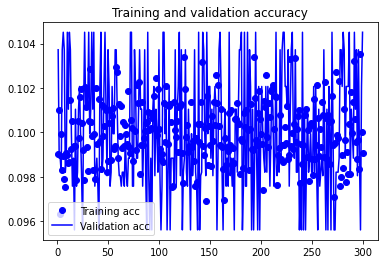

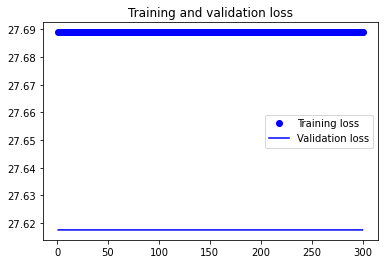

In [17]:
## Get the value from trained model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

## Plot the result
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
## Evaluate the model
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
166/166 [==============================] - 0s 425us/step - loss: 27.4159 - accuracy: 0.0975
test loss, test acc: [27.41588020324707, 0.09750684350728989]
